In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/Preprocessed_Bank_Customer_Churn_Prediction.csv')

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [13]:
from sklearn.metrics import roc_curve, auc

def auc_plot(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
# log1p 변환 수행
# skewed_columns = ['age', 'balance', 'estimated_salary', 'credit_score']
skewed_columns = ['age']

for column in skewed_columns:
    df[column] = df[column].apply(np.log1p)
    
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,3.761200,2,0.00,1,1,1,101348.88,1
1,608,2,1,3.737670,1,83807.86,1,0,1,112542.58,0
2,502,0,1,3.761200,8,159660.80,3,1,0,113931.57,1
3,699,0,1,3.688879,1,0.00,2,0,0,93826.63,0
4,850,2,1,3.784190,2,125510.82,1,1,1,79084.10,0


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 정규화 (Normalization) - 0과 1 사이로 변환
scaler = StandardScaler()

X = df.drop('churn', axis=1)
y = df['churn']


# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# %pip install catboost

In [17]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

ada_best_params = {
    'learning_rate': 1, 
    'n_estimators': 450
}

ada_best_params = {
    'n_estimators': 297, 
    'learning_rate': 0.29436353114378083
}

ada = AdaBoostClassifier(random_state=42, **ada_best_params)

cat_best_params = {
    'depth': 4, 
    'iterations': 100, 
    'learning_rate': 0.1
}
cat_best_params = {
    'iterations': 938,
    'depth': 4,
    'learning_rate': 0.04029667375026597,
    'random_strength': 62,
    'bagging_temperature': 1.0589520689603074,
    'od_type': 'Iter',
    'od_wait': 49,
    'l2_leaf_reg': 606.8679965211409,
    'border_count': 247
}
cat = CatBoostClassifier(random_state=42, **cat_best_params, verbose=0, class_weights=[1, 2.21])
# cat = CatBoostClassifier(random_state=42, **cat_best_params, verbose=0, class_weights=[1, 50])

xgb_best_params = {
'colsample_bytree': 0.998835926756326,
    'learning_rate': 0.05918736154295684,
    'max_depth': 4,
    'min_child_weight': 4,
    'n_estimators': 152,
    'subsample': 0.7171956369176462,
    'scale_pos_weight': 1.9,  # Recall 최적화된 비율
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}
xgb = XGBClassifier(random_state=42, **xgb_best_params)

rf_best_params = {
    'n_estimators':200, 
    'max_depth':15, 
    'min_samples_leaf':2, 
    'min_samples_split':5
}
rf_best_params = {'n_estimators': 153,
    'max_depth': 6,
    'min_samples_split': 6,
    'min_samples_leaf': 2,
    'max_features': 3
}
rf = RandomForestClassifier(random_state=42, **rf_best_params, verbose=0)

              precision    recall  f1-score   support

           0     0.9110    0.9083    0.9097      2389
           1     0.6456    0.6530    0.6493       611

    accuracy                         0.8563      3000
   macro avg     0.7783    0.7807    0.7795      3000
weighted avg     0.8570    0.8563    0.8566      3000



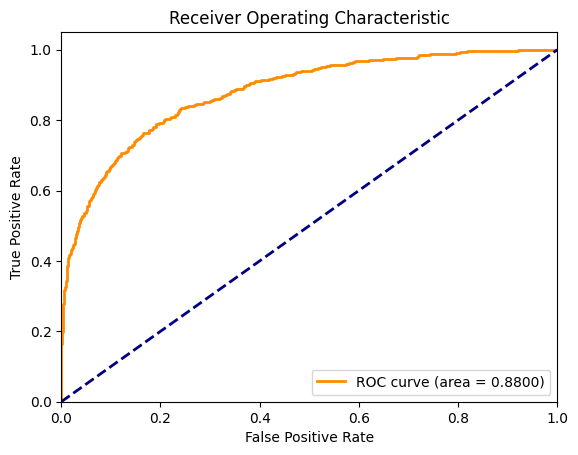

In [18]:
from sklearn.metrics import classification_report

cat.fit(X_train, y_train)

# 모델 평가
y_pred = cat.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(cat, X_test, y_test)

              precision    recall  f1-score   support

           0     0.9071    0.9196    0.9133      2389
           1     0.6678    0.6318    0.6493       611

    accuracy                         0.8610      3000
   macro avg     0.7875    0.7757    0.7813      3000
weighted avg     0.8584    0.8610    0.8595      3000



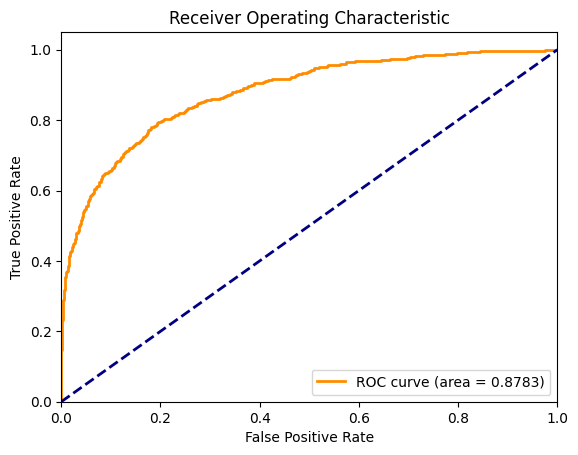

In [19]:
xgb.fit(X_train, y_train)

# 모델 평가

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(xgb, X_test, y_test)

              precision    recall  f1-score   support

           0     0.8667    0.9824    0.9209      2389
           1     0.8562    0.4092    0.5537       611

    accuracy                         0.8657      3000
   macro avg     0.8614    0.6958    0.7373      3000
weighted avg     0.8645    0.8657    0.8461      3000



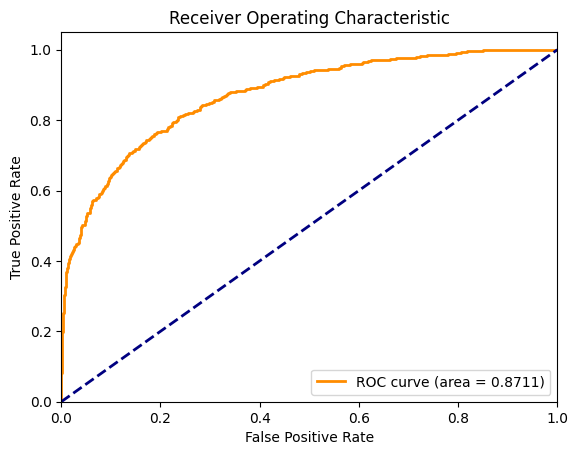

In [20]:
rf.fit(X_train, y_train)

# 모델 평가

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(rf, X_test, y_test)

/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


              precision    recall  f1-score   support

           0     0.8233    0.9807    0.8951      2389
           1     0.7013    0.1768    0.2824       611

    accuracy                         0.8170      3000
   macro avg     0.7623    0.5788    0.5887      3000
weighted avg     0.7984    0.8170    0.7703      3000



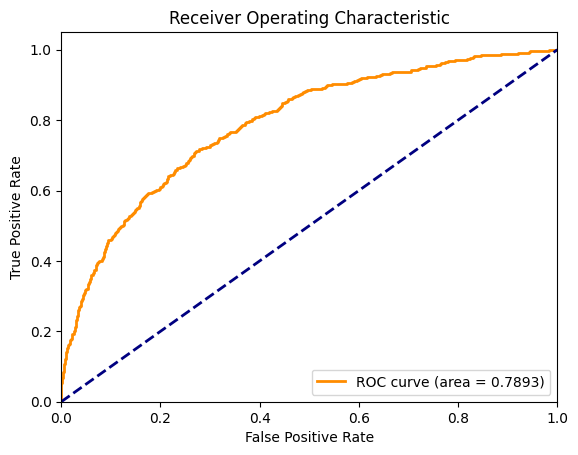

In [21]:
from sklearn.linear_model import LogisticRegression

lr_best_params = {'class_weight': None, 'l1_ratio': 0.01, 'max_iter': 5000, 'C': 0.1, 'tol': 0.0001161188854094851}

lr = LogisticRegression(**lr_best_params, random_state=42)

lr.fit(X_train, y_train)

# 모델 평가

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(lr, X_test, y_test)

              precision    recall  f1-score   support

           0     0.8645    0.9803    0.9188      2389
           1     0.8385    0.3993    0.5410       611

    accuracy                         0.8620      3000
   macro avg     0.8515    0.6898    0.7299      3000
weighted avg     0.8592    0.8620    0.8419      3000



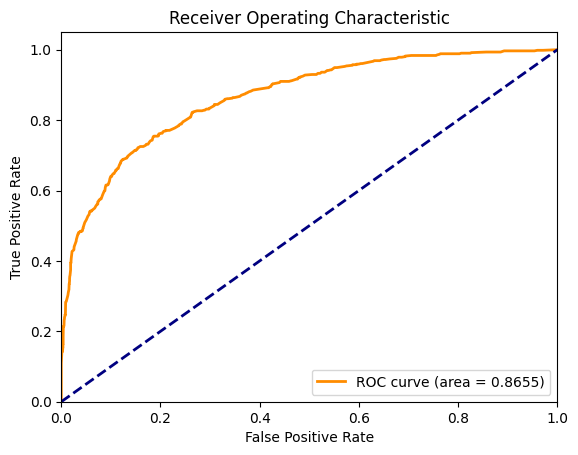

In [22]:
ada.fit(X_train, y_train)

# 모델 평가

y_pred = ada.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(ada, X_test, y_test)